In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import read_quote      as rq
import stock_functions as sf
import df_visualizations as dv
import remap_values as rv
import fill_values as fv

import random
import pickle

import sys
import time

In [2]:
from sklearn.svm            import SVR
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble       import BaggingRegressor
from sklearn.ensemble       import AdaBoostRegressor

from sklearn.multioutput    import MultiOutputRegressor

from sklearn.utils          import shuffle

from sklearn.metrics        import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.multioutput    import MultiOutputRegressor

In [3]:
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 10)

In [4]:
roll_nums = [3,5,8,10,15,20,25,30]  # Generate an algorithm for predicting every few days
mom_nums  = [3,5,8,10,15,20,25,30]  # Momentum has many good tracers
rsi_nums  = [10,15,20,25,30]        # Good for some long term trends
band_nums = [5,8,10,15,20,25]       # A few trace different areas well

In [5]:
inpFileList = ['aapl','acm' ,'awk' ,'amzn','awr' ,'ba'  ,'bac' ,'c'   ,'cat' ,'cop' ,'cvx' ,'dal' ,
               'dd'  ,'farm','fdp' ,'gnc' ,'hes' ,'ibm' ,'mas' ,'mcd' ,'mon' ,'msex','msft','nflx',
               'sbux','strl','tgt' ,'tsla','ups' ,'xom' ,'xpo' ,'vmc' ]

In [6]:
scaled_df = sf.get_scaled_data( inpFileList, roll_nums, mom_nums, rsi_nums, band_nums )

In [6]:
#scaled_df = sf.gen_pca_attributes( scaled_df, mom_nums, rsi_nums, band_nums, n_mom=3, n_rsi=2, n_ban=2 )

In [7]:
# Read in each stock, and perform reduction
#    Break into train, test sets
#    Store train, test sets in arrays
# For each regressor predicting a certain num of days...
#    Manually cross validate, testing and scoring each set

In [7]:
# Mix up the list
shuff_scaled_df = shuffle( scaled_df )


# Seperate features from target data
close_list = ['close']
for i in roll_nums:
    close_list.append( 'close_mean_'+str(i) )

targets  = shuff_scaled_df[close_list]
features = shuff_scaled_df.drop( close_list, axis=1 )



n_elements = shuff_scaled_df.shape[0]

# Set the fraction of data we will train over
percent_train = 0.8

# Size of training set
n_train = int( percent_train * n_elements )


# Seperate training and test data
train_features = features[ : n_train   ]
test_features  = features[   n_train : ]

train_targets  =  targets[ : n_train   ].drop( 'close', axis=1 )
test_targets   =  targets[   n_train : ].drop( 'close', axis=1 )

In [8]:
# Gets the location of not null values
train_not_null_locations = train_targets.notnull().all( axis=1 )==1
test_not_null_locations  =  test_targets.notnull().all( axis=1 )==1

# Take features and targets that are not null
train_x = train_features[ train_not_null_locations ].values
test_x  =  test_features[  test_not_null_locations ].values

train_y = train_targets[ train_not_null_locations ].values
test_y  =  test_targets[  test_not_null_locations ].values

ad_mult_reg = MultiOutputRegressor( AdaBoostRegressor( base_estimator=RandomForestRegressor( n_estimators=20, max_features=0.7 ), 
#                            loss='exponential', n_estimators=10 ) )
                            loss='exponential', n_estimators=5 ) )
#                            loss='exponential', n_estimators=3 ) )

ad_mult_reg.fit( train_x, train_y )

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         learning_rate=1.0, loss='exponential', n_estimators=5,
         random_state=None),
           n_jobs=1)

In [9]:
test_60 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] ) ) :
    mse = mean_squared_error( test_y[i-1], test_60[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.28736, Percent ME : 36.03992
 close_mean_5 MSE :  0.01817, Percent ME :  9.06243
 close_mean_7 MSE :  0.02099, Percent ME :  9.73959
close_mean_10 MSE :  0.00909, Percent ME :  6.41166
close_mean_12 MSE :  0.02232, Percent ME : 10.04452
close_mean_15 MSE :  0.02216, Percent ME : 10.00922


In [29]:
test_70 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] ) ) :
    mse = mean_squared_error( test_y[i-1], test_70[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.11175, Percent ME : 22.26275
 close_mean_5 MSE :  0.02046, Percent ME :  9.52490
 close_mean_7 MSE :  0.01597, Percent ME :  8.41539
close_mean_10 MSE :  0.00119, Percent ME :  2.29876
close_mean_12 MSE :  0.23849, Percent ME : 32.52288
close_mean_15 MSE :  0.26986, Percent ME : 34.59590


In [12]:
test_80 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00034, Percent ME :  1.28400
 close_mean_5 MSE :  0.00052, Percent ME :  1.57940
 close_mean_7 MSE :  0.00769, Percent ME :  6.09548
close_mean_10 MSE :  0.00520, Percent ME :  5.01383
close_mean_12 MSE :  0.04772, Percent ME : 15.18780
close_mean_15 MSE :  0.01710, Percent ME :  9.09208
close_mean_20 MSE :  0.04250, Percent ME : 14.33349
close_mean_25 MSE :  0.10339, Percent ME : 22.35573


In [8]:
test_80_5 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_5[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00052, Percent ME :  1.58310
 close_mean_5 MSE :  0.01097, Percent ME :  7.28296
 close_mean_7 MSE :  0.02160, Percent ME : 10.21904
close_mean_10 MSE :  0.00542, Percent ME :  5.11623
close_mean_12 MSE :  0.04154, Percent ME : 14.17041
close_mean_15 MSE :  0.01140, Percent ME :  7.42228
close_mean_20 MSE :  0.01214, Percent ME :  7.66086
close_mean_25 MSE :  0.06858, Percent ME : 18.20686


In [8]:
test_all = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_all[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.04622, Percent ME : 16.03829
 close_mean_5 MSE :  0.00280, Percent ME :  3.95061
 close_mean_7 MSE :  0.06953, Percent ME : 19.67037
close_mean_10 MSE :  0.03379, Percent ME : 13.71227
close_mean_12 MSE :  0.00471, Percent ME :  5.11735
close_mean_15 MSE :  0.26712, Percent ME : 38.55589
close_mean_18 MSE :  0.02227, Percent ME : 11.13333
close_mean_20 MSE :  0.00127, Percent ME :  2.66170
close_mean_23 MSE :  0.00853, Percent ME :  6.89029
close_mean_25 MSE :  0.02849, Percent ME : 12.59120
close_mean_28 MSE :  0.00738, Percent ME :  6.40677
close_mean_30 MSE :  0.02438, Percent ME : 11.64905


In [8]:
test_80_3_all = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_3_all[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.01164, Percent ME :  8.63749
 close_mean_5 MSE :  0.00212, Percent ME :  3.68463
 close_mean_7 MSE :  0.08406, Percent ME : 23.21046
close_mean_10 MSE :  0.00056, Percent ME :  1.89508
close_mean_12 MSE :  0.00012, Percent ME :  0.86886
close_mean_15 MSE :  0.00403, Percent ME :  5.08291
close_mean_18 MSE :  0.01355, Percent ME :  9.31947
close_mean_20 MSE :  0.04023, Percent ME : 16.05616
close_mean_23 MSE :  0.00035, Percent ME :  1.48873
close_mean_25 MSE :  0.00362, Percent ME :  4.81892
close_mean_28 MSE :  0.08284, Percent ME : 23.04127
close_mean_30 MSE :  0.00043, Percent ME :  1.66966


In [9]:
test_80_3_most = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_3_most[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(abs(test_y) ) )

 close_mean_3 MSE :  0.00222, Percent ME :  0.42910
 close_mean_5 MSE :  0.01836, Percent ME :  1.23313
 close_mean_8 MSE :  0.01501, Percent ME :  1.11468
close_mean_10 MSE :  0.01245, Percent ME :  1.01514
close_mean_15 MSE :  0.00850, Percent ME :  0.83905
close_mean_20 MSE :  0.01199, Percent ME :  0.99655
close_mean_25 MSE :  0.00141, Percent ME :  0.34111
close_mean_30 MSE :  0.00918, Percent ME :  0.87200


In [9]:
test_80_5_most = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_5_most[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00649, Percent ME : 12.98574
 close_mean_5 MSE :  0.00211, Percent ME :  7.41025
 close_mean_8 MSE :  0.00104, Percent ME :  5.20778
close_mean_10 MSE :  0.00210, Percent ME :  7.37992
close_mean_15 MSE :  0.00080, Percent ME :  4.55972
close_mean_20 MSE :  0.00079, Percent ME :  4.52991
close_mean_25 MSE :  0.00005, Percent ME :  1.13432
close_mean_30 MSE :  0.00121, Percent ME :  5.60555


In [10]:
pred_values = test_80_5_most

std_dict = {}

for i in range( 0, len( close_list[1:] ) ) :
    rmse = np.sqrt( mean_squared_error( test_y[i], pred_values[i] ) )
    col  = 'std_' + str( roll_nums[i] )
    std_dict[col] = rmse
    print '%13s   RMSE : %8.5f,   RMSE/mean : %8.5f' % ( close_list[i+1], rmse, rmse/np.mean( abs(test_y)) )
    
print std_dict

 close_mean_3   RMSE :  0.08055,   RMSE/mean :  1.74393
 close_mean_5   RMSE :  0.04596,   RMSE/mean :  0.99516
 close_mean_8   RMSE :  0.03230,   RMSE/mean :  0.69938
close_mean_10   RMSE :  0.04578,   RMSE/mean :  0.99109
close_mean_15   RMSE :  0.02828,   RMSE/mean :  0.61235
close_mean_20   RMSE :  0.02810,   RMSE/mean :  0.60835
close_mean_25   RMSE :  0.00704,   RMSE/mean :  0.15233
close_mean_30   RMSE :  0.03477,   RMSE/mean :  0.75280
{'std_25': 0.0070359109472509828, 'std_30': 0.034769905905065297, 'std_20': 0.028097955342065623, 'std_15': 0.02828284048045128, 'std_10': 0.04577586641613135, 'std_5': 0.045963995633090886, 'std_3': 0.080547427926956711, 'std_8': 0.03230259625805873}


In [109]:
#with open( 'data/temp.pkl', 'wb' ) as handle:
#    pickle.dump( ad_mult_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
with open( 'data/temp.pkl', 'rb' ) as handle:
    ad_mult_reg = pickle.load( handle )

In [14]:
# Test on this quote

In [31]:
quote_name = 'aapl'


# Generate df with the actual rolling averages
close_df = rq.readQuote( 'quotes/'+ quote_name +'.csv' )
close_df = pd.merge( close_df['close'].to_frame(), sf.generate_rolling_close( close_df, roll_nums, onlyMean=True ), 
                    left_index=True, right_index=True )
close_means = close_df.columns.values


# Generate predicted rolling mean percentage increases
pred_df     = sf.get_scaled_data( [quote_name], roll_nums, mom_nums, rsi_nums, band_nums ).dropna()
pred_values = ad_mult_reg.predict( pred_df.drop( close_means, axis=1 ) )


# Adjust close to match pred df shape
close_df = close_df.ix[ pred_df.index.values ].dropna()

# Pred percent increase = future/now - 1
for i in range( 0 , pred_values.shape[1] ):
    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = ( pred_values[:,i] + 1 ) * close_df[ 'close_mean_' + str( roll_nums[i] ) ]
    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = close_df[ 'pred_mean_' + str( roll_nums[i] ) ].shift( -roll_nums[i]+1 )
#    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = ( close_df[ 'pred_mean_' + str( roll_nums[i] ) ] + 
#                                                       close_df[ 'pred_mean_' + str( roll_nums[i] ) ].shift(-1) ) / 2.
close_df = close_df.dropna()

In [32]:
del ad_mult_reg

In [16]:
# Smooth and shift

In [33]:
temp = close_df.copy()

In [34]:
with open( 'data/smooth_shift.pkl', 'rb' ) as handle:
    smooth_shift = pickle.load( handle )
    
    # Tweak the difference in rolling means per day
    # Lots of noise, this may force less noise, might not. We will see
    for i in range( 0, len(roll_nums) ):

        roll = str( roll_nums[i] )
        if ( smooth_shift['smooth_'+str(roll_nums[i])] > 1 ):
            close_df['pred_mean_'+roll] = close_df['pred_mean_'+roll].values[::-1]
            close_df['pred_mean_'+roll] = close_df['pred_mean_'+roll].rolling( smooth_shift['smooth_'+str(roll_nums[i])]).mean()
            close_df['pred_mean_'+roll] = close_df['pred_mean_'+roll].shift  (-smooth_shift[ 'shift_'+str(roll_nums[i])])
            close_df['pred_mean_'+roll] = close_df['pred_mean_'+roll].values[::-1]
        else:
            close_df['pred_mean_'+roll] = close_df['pred_mean_'+roll]

In [77]:
foo = fv.pred_from_mean( close_df, roll_nums )
foo.head()

,close,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_20,pred_21,pred_22,pred_23,pred_24,pred_25,pred_26,pred_27,pred_28,pred_29
date,,,,,,,,,,,,,,,,,,,,,
2017/01/26,121.94,121.217051,120.494102,119.376143,119.041432,120.164515,120.114399,120.064283,123.801552,125.557383,...,119.237909,118.694575,118.151241,117.607907,117.064573,106.519019,106.463912,106.408805,106.353697,106.298590
2017/01/25,121.88,120.782651,119.685302,119.965913,119.817415,120.022901,120.034299,120.045697,121.820362,122.720070,...,119.317090,118.867944,118.418799,117.969653,117.520507,107.514079,107.136682,106.759285,106.381888,106.004491
2017/01/24,119.97,120.434354,120.898708,120.356598,120.342460,119.398872,119.207326,119.015781,119.887867,120.140714,...,119.179484,118.788848,118.398212,118.007576,117.616940,108.287204,107.665743,107.044281,106.422820,105.801358
2017/01/23,120.08,120.195094,120.310188,119.552362,119.435501,119.770951,119.814669,119.858387,118.582420,118.469801,...,118.825092,118.457286,118.089481,117.721675,117.353870,108.838395,108.051094,107.263793,106.476492,105.689191
2017/01/20,120.00,120.243406,120.486813,118.601367,118.302814,119.299817,119.439507,119.579197,117.740229,117.563828,...,118.214525,117.883663,117.552801,117.221939,116.891077,109.167653,108.292737,107.417822,106.542906,105.667990


In [80]:
# Generate frame with all predictions for a day on the same row

In [81]:
aligned_frame = foo.copy()
for i in range( 1, foo.shape[1] ):
    aligned_frame['pred_'+str(i)] = aligned_frame['pred_'+str(i)].shift( -i )
aligned_frame = aligned_frame.dropna()
aligned_frame.head()

,close,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_20,pred_21,pred_22,pred_23,pred_24,pred_25,pred_26,pred_27,pred_28,pred_29
date,,,,,,,,,,,,,,,,,,,,,
2017/01/26,121.94,120.782651,120.898708,119.552362,118.302814,119.199906,117.358699,113.915898,116.107399,117.422478,...,111.368813,111.817662,112.941269,110.499210,110.195629,109.525002,115.451853,119.531527,121.317285,123.593296
2017/01/25,121.88,120.434354,120.310188,118.601367,118.506770,117.698151,114.618177,113.235994,116.714821,118.018830,...,111.373615,112.857980,110.840816,110.795501,109.166989,114.270291,118.007605,119.711419,121.912794,115.531283
2017/01/24,119.97,120.195094,120.486813,118.798598,119.383261,115.320455,113.978798,114.450944,117.430751,120.274795,...,112.774691,111.182421,111.395374,109.622332,102.923850,116.483684,118.105552,120.232292,115.058106,119.995427
2017/01/23,120.08,120.243406,121.027308,119.395411,118.664644,114.721602,114.900102,115.194415,119.690117,118.059965,...,111.524026,111.995246,110.077674,103.870823,102.990819,116.499686,118.551791,114.584930,119.380744,129.847603
2017/01/20,120.00,120.403654,118.934468,118.831849,118.241125,115.349260,115.422121,115.907672,118.230211,117.867714,...,112.595118,110.533017,104.817797,103.641565,102.410616,116.871289,114.111753,118.766061,128.238052,130.576615


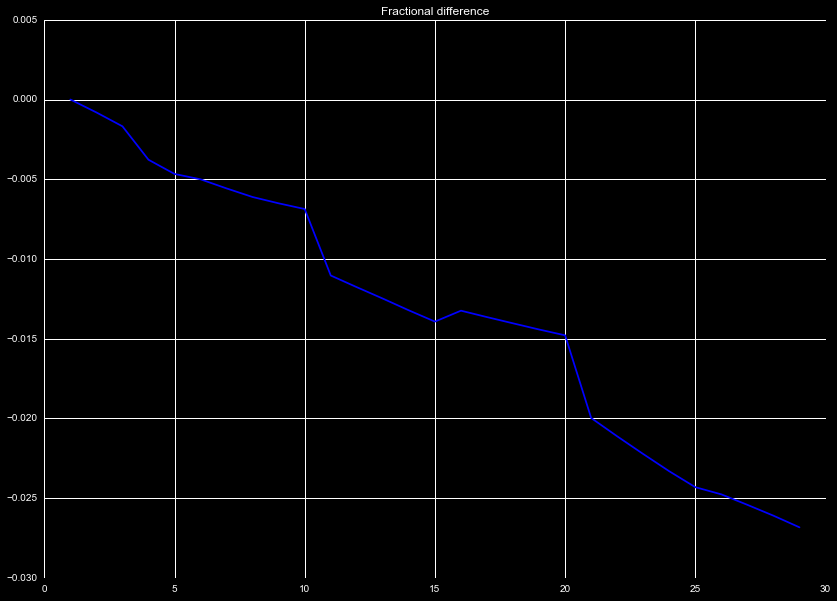

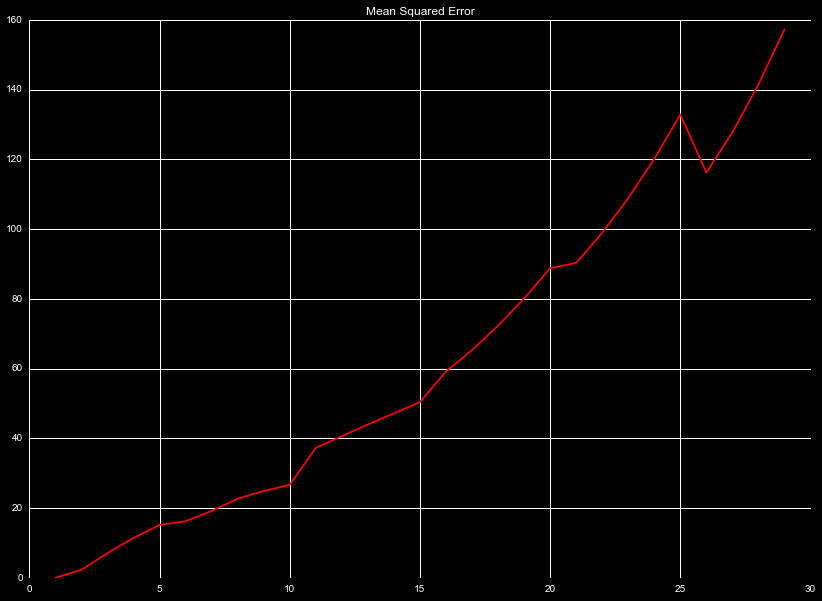

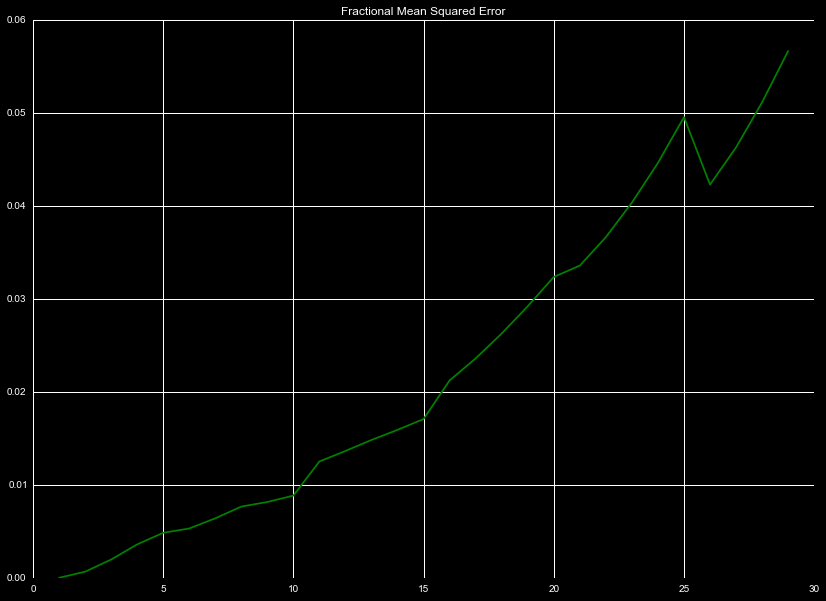

In [82]:
# Predictions over the whole range
tot_diff  = np.zeros( aligned_frame.shape[1]-1 )
mse_diff  = np.zeros( aligned_frame.shape[1]-1 )
fmse_diff = np.zeros( aligned_frame.shape[1]-1 )


for i in range( 1, len(aligned_frame.columns.values[1:]) ):
    col         =   aligned_frame.columns.values[i]
    tot_diff[i] = ( aligned_frame[col] / aligned_frame['close'] - 1      ).mean()
    mse_diff[i] =(( aligned_frame[col] - aligned_frame['close']     )**2 ).mean()
    fmse_diff[i]=(( aligned_frame[col] / aligned_frame['close'] - 1 )**2 ).mean()
    
plt.plot( range(1,30), tot_diff, color='b' )
plt.title( 'Fractional difference' )
plt.show()

plt.plot( range(1,30), mse_diff, color='r' )
plt.title( 'Mean Squared Error' )
plt.show()

plt.plot( range(1,30), fmse_diff, color='g' )
plt.title( 'Fractional Mean Squared Error' )
plt.show()